In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\anshu\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
mnist = input_data.read_data_sets("../03-Convolutional-Neural-Networks/MNIST_data/",one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../03-Convolutional-Neural-Networks/MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../03-Convolutional-Neural-Networks/MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ../03-Convolutional-Neural-Networks/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../03-Convolutional-Neural-Networks/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


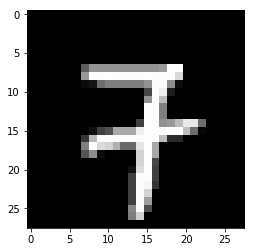

In [3]:
plt.imshow(mnist.train.images[14].reshape(28,28), cmap='gray')

In [4]:
num_steps = 100000
batch_size = 64
learning_rate = 0.001
image_dim = 784 
gen_hidden1_dim = 128
gen_hidden2_dim = 128
disc_hidden1_dim = 128
disc_hidden2_dim = 128
noise_dim = 100

In [5]:
def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.))

In [6]:
weights = {
    'gen_hidden1': tf.Variable(glorot_init([noise_dim, gen_hidden1_dim])),
    'gen_hidden2': tf.Variable(glorot_init([gen_hidden1_dim, gen_hidden2_dim])),
    'gen_out': tf.Variable(glorot_init([gen_hidden2_dim, image_dim])),
    'disc_hidden1': tf.Variable(glorot_init([image_dim, disc_hidden1_dim])),
    'disc_hidden2': tf.Variable(glorot_init([disc_hidden1_dim, disc_hidden2_dim])),
    'disc_out': tf.Variable(glorot_init([disc_hidden2_dim, 1])),
}
biases = {
    'gen_hidden1': tf.Variable(tf.zeros([gen_hidden1_dim])),
    'gen_hidden2': tf.Variable(tf.zeros([gen_hidden2_dim])),
    'gen_out': tf.Variable(tf.zeros([image_dim])),
    'disc_hidden1': tf.Variable(tf.zeros([disc_hidden1_dim])),
    'disc_hidden2': tf.Variable(tf.zeros([disc_hidden2_dim])),
    'disc_out': tf.Variable(tf.zeros([1])),
}

In [7]:
def generator(x):
    hidden_layer1 = tf.matmul(x, weights['gen_hidden1'])
    hidden_layer1 = tf.add(hidden_layer1, biases['gen_hidden1'])
    hidden_layer1 = tf.nn.leaky_relu(hidden_layer1,alpha=0.01)
    
    hidden_layer2 = tf.matmul(hidden_layer1, weights['gen_hidden2'])
    hidden_layer2 = tf.add(hidden_layer2, biases['gen_hidden2'])
    hidden_layer2 = tf.nn.leaky_relu(hidden_layer2,alpha=0.01)
    
    
    out_layer = tf.matmul(hidden_layer2, weights['gen_out'])
    out_layer = tf.add(out_layer, biases['gen_out'])
    out_layer = tf.nn.tanh(out_layer)
    return out_layer

In [8]:
def discriminator(x):
    hidden_layer1 = tf.matmul(x, weights['disc_hidden1'])
    hidden_layer1 = tf.add(hidden_layer1, biases['disc_hidden1'])
    hidden_layer1 = tf.nn.leaky_relu(hidden_layer1,alpha=0.01)
    
    hidden_layer2 = tf.matmul(hidden_layer1, weights['disc_hidden2'])
    hidden_layer2 = tf.add(hidden_layer2, biases['disc_hidden2'])
    hidden_layer2 = tf.nn.leaky_relu(hidden_layer2,alpha=0.01)
    
    
    out_layer = tf.matmul(hidden_layer2, weights['disc_out'])
    out_layer = tf.add(out_layer, biases['disc_out'])
    out_layero = tf.nn.sigmoid(out_layer)
    return out_layero,out_layer

In [9]:
gen_input = tf.placeholder(tf.float32, shape=[None, noise_dim])
disc_input = tf.placeholder(tf.float32, shape=[None, image_dim])

In [10]:
gen_sample = generator(gen_input)

In [11]:
disc_real,logits_real = discriminator(disc_input)
disc_fake,logits_fake = discriminator(gen_sample)

In [12]:
D_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_real,labels=tf.ones_like(logits_real)*.9))
D_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake,labels=tf.zeros_like(logits_fake)))

In [13]:
disc_loss = D_real_loss + D_fake_loss

In [14]:
gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake,labels=tf.ones_like(logits_fake)))


In [15]:
optimizer_gen = tf.train.AdamOptimizer(learning_rate=learning_rate)
optimizer_disc = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [16]:
gen_vars = [weights['gen_hidden1'], weights['gen_out'],
            weights['gen_hidden2'], 
            biases['gen_hidden1'], biases['gen_out'],biases['gen_hidden1']]

In [17]:
disc_vars = [weights['disc_hidden1'], weights['disc_out'],weights['disc_hidden2'],
            biases['disc_hidden1'], biases['disc_out'],biases['disc_hidden2']]

In [18]:
train_gen = optimizer_gen.minimize(gen_loss, var_list=gen_vars)
train_disc = optimizer_disc.minimize(disc_loss, var_list=disc_vars)

In [19]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [21]:
for i in range(1, num_steps+1):
    
    batch_image, _ = mnist.train.next_batch(batch_size)
    batch_x = batch_image.reshape((batch_size,784))
    batch_x = batch_x*2 -1
    
    z = np.random.uniform(-1., 1., size=[batch_size, noise_dim])

    
    feed_dict = {disc_input: batch_x, gen_input: z}
    _, _, gl, dl = sess.run([train_gen, train_disc, gen_loss, disc_loss],
                            feed_dict=feed_dict)
    if i % 2000 == 0 or i == 1:
        print('Step %i: Generator Loss: %f, Discriminator Loss: %f' % (i, gl, dl))

Step 1: Generator Loss: 0.326894, Discriminator Loss: 1.698704
Step 2000: Generator Loss: 2.896327, Discriminator Loss: 0.568556
Step 4000: Generator Loss: 5.946741, Discriminator Loss: 1.116622
Step 6000: Generator Loss: 1.602587, Discriminator Loss: 1.163254
Step 8000: Generator Loss: 5.871134, Discriminator Loss: 0.367179
Step 10000: Generator Loss: 2.110141, Discriminator Loss: 0.857247
Step 12000: Generator Loss: 2.817628, Discriminator Loss: 0.681384
Step 14000: Generator Loss: 3.589025, Discriminator Loss: 0.586178
Step 16000: Generator Loss: 2.414821, Discriminator Loss: 0.704427
Step 18000: Generator Loss: 2.187096, Discriminator Loss: 0.877538
Step 20000: Generator Loss: 1.805661, Discriminator Loss: 0.837398
Step 22000: Generator Loss: 1.925250, Discriminator Loss: 0.720948
Step 24000: Generator Loss: 2.432735, Discriminator Loss: 0.931917
Step 26000: Generator Loss: 2.432887, Discriminator Loss: 0.818401
Step 28000: Generator Loss: 1.880650, Discriminator Loss: 1.044151
Ste

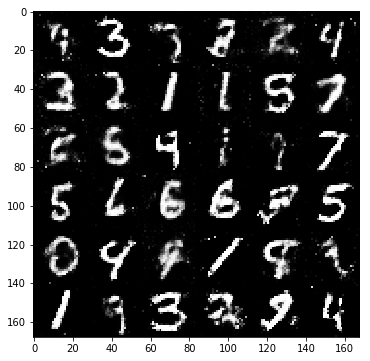

In [32]:
n = 6
canvas = np.empty((28 * n, 28 * n))
for i in range(n):   
    z = np.random.uniform(-1., 1., size=[n, noise_dim])    
    g = sess.run(gen_sample, feed_dict={gen_input: z})
    #g = -1 * (g - 1)
    for j in range(n):
        
        canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[j].reshape([28, 28])

plt.figure(figsize=(n, n))
plt.imshow(canvas, origin="upper", cmap="gray")
plt.show()